In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/devkit_doc.pdf
/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/SegmentationObject/2010_002106.png
/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/SegmentationObject/2007_004121.png
/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/SegmentationObject/2009_003172.png
/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/SegmentationObject/2007_005828.png
/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/SegmentationObject/2011_000208.png
/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/SegmentationObject/2010_000426.png
/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/SegmentationObject/2011_001341.png
/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/SegmentationObject/2009_002291.png
/kaggle/input/pascal-voc-2012-dataset/V

In [2]:
import os
import sys
import random
import time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision.models.segmentation import fcn_resnet50

print(f"Python: {sys.version.split()[0]}")
print(f"PyTorch: {torch.__version__}")
print(f"Torchvision: {torchvision.__version__}")

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Python: 3.11.13
PyTorch: 2.6.0+cu124
Torchvision: 0.21.0+cu124
Device: cuda


In [3]:
# Find the correct dataset path
def find_voc_dataset():
    """Automatically find VOC dataset path in Kaggle input directory"""
    input_base = Path('/kaggle/input')
    
    # Common paths to check
    potential_paths = [
        input_base / 'pascal-voc-2012-dataset' / 'VOC2012_train_val' / 'VOC2012_train_val',
        input_base / 'pascal-voc-2012-dataset' / 'VOCdevkit' / 'VOC2012',
        input_base / 'pascal-voc-2012-dataset' / 'VOC2012',
        input_base / 'pascal-voc-2012-dataset',
    ]
    
    for p in potential_paths:
        if p.exists() and (p / 'JPEGImages').exists():
            print(f"✓ Found dataset at: {p}")
            return p
    
    # Fallback: search for JPEGImages directory
    print("Searching for JPEGImages directory...")
    for root, dirs, files in os.walk(input_base):
        if 'JPEGImages' in dirs:
            found_path = Path(root)
            print(f"✓ Found dataset at: {found_path}")
            return found_path
    
    raise FileNotFoundError("Could not find VOC dataset. Please check the input directory.")

ROOT = find_voc_dataset()
print(f"\nDataset structure:")
for item in sorted(ROOT.iterdir()):
    print(f"  {item.name}")

# Verify critical directories
assert (ROOT / 'JPEGImages').exists(), "JPEGImages directory not found"
assert (ROOT / 'SegmentationClass').exists(), "SegmentationClass directory not found"

jpg_count = len(list((ROOT / 'JPEGImages').glob('*.jpg')))
png_count = len(list((ROOT / 'SegmentationClass').glob('*.png')))
print(f"\n✓ Found {jpg_count} images and {png_count} masks")

✓ Found dataset at: /kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val

Dataset structure:
  Annotations
  ImageSets
  JPEGImages
  SegmentationClass
  SegmentationObject
  devkit_doc.pdf

✓ Found 17125 images and 2913 masks


In [4]:
def create_pascal_label_colormap():
    """Creates a label colormap used in PASCAL VOC segmentation benchmark."""
    colormap = np.zeros((256, 3), dtype=np.uint8)
    
    for i in range(256):
        r = g = b = 0
        cid = i
        for j in range(8):
            r |= ((cid >> 0) & 1) << (7 - j)
            g |= ((cid >> 1) & 1) << (7 - j)
            b |= ((cid >> 2) & 1) << (7 - j)
            cid >>= 3
        colormap[i] = [r, g, b]
    
    return colormap

VOC_COLORMAP = create_pascal_label_colormap()
VOC_CLASSES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog',
    'horse', 'motorbike', 'person', 'pottedplant', 'sheep',
    'sofa', 'train', 'tvmonitor'
]

def mask_to_class_index(mask_pil):
    """Convert RGB mask to class indices (0-20) with 255 for ignore."""
    arr = np.array(mask_pil.convert('RGB'), dtype=np.uint8)
    h, w, _ = arr.shape
    
    # Create mapping from color to class index
    color_to_idx = {tuple(VOC_COLORMAP[i]): i for i in range(21)}
    
    # Initialize with ignore index
    result = np.full((h, w), 255, dtype=np.uint8)
    
    # Map each pixel
    arr_flat = arr.reshape(-1, 3)
    result_flat = np.full(arr_flat.shape[0], 255, dtype=np.uint8)
    
    for color, idx in color_to_idx.items():
        matches = np.all(arr_flat == color, axis=1)
        result_flat[matches] = idx
    
    return result_flat.reshape(h, w)

def class_index_to_rgb(mask_arr):
    """Convert class indices back to RGB for visualization."""
    h, w = mask_arr.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    
    for cls_idx in range(21):
        rgb[mask_arr == cls_idx] = VOC_COLORMAP[cls_idx]
    
    return rgb

print(f"✓ VOC colormap created with {len(VOC_CLASSES)} classes")

✓ VOC colormap created with 21 classes


In [5]:
class PascalVOCDataset(Dataset):
    """Pascal VOC 2012 Segmentation Dataset"""
    
    def __init__(self, root, image_ids, img_size=(320, 320), augment=False):
        self.root = Path(root)
        self.image_ids = image_ids
        self.img_size = img_size
        self.augment = augment
        
        self.img_dir = self.root / 'JPEGImages'
        self.mask_dir = self.root / 'SegmentationClass'
        
        # Data augmentation transforms
        self.color_jitter = transforms.ColorJitter(
            brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1
        )
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        
        # Load image and mask
        img_path = self.img_dir / f"{img_id}.jpg"
        mask_path = self.mask_dir / f"{img_id}.png"
        
        if not img_path.exists() or not mask_path.exists():
            # Return next valid item if this one is missing
            return self.__getitem__((idx + 1) % len(self))
        
        img = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path)
        
        # Resize
        img = img.resize(self.img_size, Image.BILINEAR)
        mask = mask.resize(self.img_size, Image.NEAREST)
        
        # Apply augmentations
        if self.augment:
            # Random horizontal flip
            if random.random() > 0.5:
                img = img.transpose(Image.FLIP_LEFT_RIGHT)
                mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
            
            # Color jittering (only on image)
            img = self.color_jitter(img)
        
        # Convert mask to class indices
        mask_arr = mask_to_class_index(mask)
        
        # Convert to tensors
        img_tensor = transforms.ToTensor()(img)
        img_tensor = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )(img_tensor)
        
        mask_tensor = torch.from_numpy(mask_arr).long()
        
        return img_tensor, mask_tensor

In [6]:
# Get all valid image IDs (those with both image and mask)
all_img_ids = [p.stem for p in sorted((ROOT / 'JPEGImages').glob('*.jpg'))]

valid_ids = []
for img_id in all_img_ids:
    img_path = ROOT / 'JPEGImages' / f'{img_id}.jpg'
    mask_path = ROOT / 'SegmentationClass' / f'{img_id}.png'
    if img_path.exists() and mask_path.exists():
        valid_ids.append(img_id)

print(f"Total valid samples: {len(valid_ids)}")

# Split into train and validation
train_ids, val_ids = train_test_split(
    valid_ids, test_size=0.15, random_state=SEED
)

print(f"Train samples: {len(train_ids)}")
print(f"Val samples: {len(val_ids)}")

# Create datasets
train_dataset = PascalVOCDataset(
    ROOT, train_ids, img_size=(320, 320), augment=True
)
val_dataset = PascalVOCDataset(
    ROOT, val_ids, img_size=(320, 320), augment=False
)

# Create dataloaders
BATCH_SIZE = 8
NUM_WORKERS = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"\n✓ DataLoaders created")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")

Total valid samples: 2913
Train samples: 2476
Val samples: 437

✓ DataLoaders created
  Train batches: 310
  Val batches: 55


Sample batch shape: images=torch.Size([8, 3, 320, 320]), masks=torch.Size([8, 320, 320])


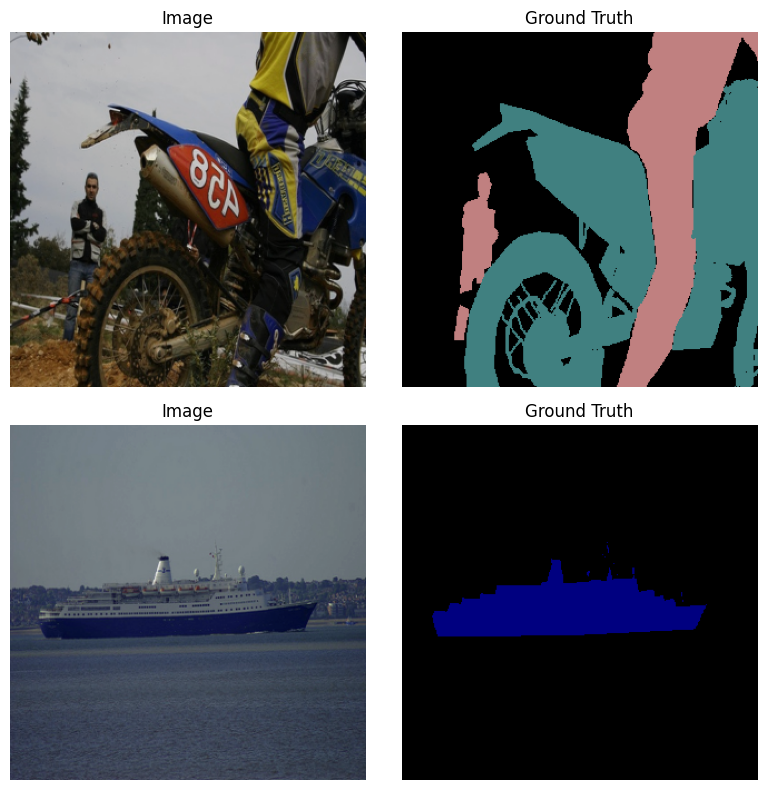

In [7]:
def denormalize(img_tensor):
    """Denormalize image tensor for visualization"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img_tensor * std + mean

def visualize_batch(images, masks, predictions=None, num_samples=4):
    """Visualize a batch of images with masks and predictions"""
    num_samples = min(num_samples, images.shape[0])
    
    cols = 3 if predictions is not None else 2
    fig, axes = plt.subplots(num_samples, cols, figsize=(cols*4, num_samples*4))
    
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_samples):
        # Denormalize and convert image
        img = denormalize(images[i]).cpu().permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        
        # Convert mask to RGB
        mask = masks[i].cpu().numpy()
        mask_rgb = class_index_to_rgb(mask)
        
        # Plot image and mask
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask_rgb)
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')
        
        # Plot prediction if available
        if predictions is not None:
            pred = predictions[i].cpu().numpy()
            pred_rgb = class_index_to_rgb(pred)
            axes[i, 2].imshow(pred_rgb)
            axes[i, 2].set_title('Prediction')
            axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show sample batch
sample_images, sample_masks = next(iter(train_loader))
print(f"Sample batch shape: images={sample_images.shape}, masks={sample_masks.shape}")
visualize_batch(sample_images, sample_masks, num_samples=2)

In [8]:
NUM_CLASSES = 21

# Load FCN-ResNet50 with pretrained backbone
model = fcn_resnet50(pretrained=False, num_classes=NUM_CLASSES, pretrained_backbone=True)
model = model.to(device)

# Loss function (ignore index 255)
criterion = nn.CrossEntropyLoss(ignore_index=255)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✓ Model initialized")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to 


✓ Model initialized
  Total parameters: 32,957,013
  Trainable parameters: 32,957,013


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [9]:
def compute_iou(pred, target, num_classes=21, ignore_index=255):
    """Compute Intersection over Union (IoU) for each class"""
    pred = pred.flatten()
    target = target.flatten()
    
    # Remove ignore index
    mask = target != ignore_index
    pred = pred[mask]
    target = target[mask]
    
    ious = []
    for cls in range(num_classes):
        pred_cls = (pred == cls)
        target_cls = (target == cls)
        
        intersection = (pred_cls & target_cls).sum().item()
        union = (pred_cls | target_cls).sum().item()
        
        if union == 0:
            ious.append(float('nan'))  # Class not present
        else:
            ious.append(intersection / union)
    
    return ious

def compute_pixel_accuracy(pred, target, ignore_index=255):
    """Compute pixel-wise accuracy"""
    mask = target != ignore_index
    correct = (pred[mask] == target[mask]).sum().item()
    total = mask.sum().item()
    return correct / total if total > 0 else 0.0

In [10]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    
    running_loss = 0.0
    running_acc = 0.0
    
    for batch_idx, (images, masks) in enumerate(loader):
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Metrics
        preds = outputs.argmax(dim=1)
        acc = compute_pixel_accuracy(preds, masks)
        
        running_loss += loss.item()
        running_acc += acc
        
        # Print progress
        if (batch_idx + 1) % 20 == 0:
            print(f"  Batch {batch_idx+1}/{len(loader)} - "
                  f"Loss: {loss.item():.4f}, Acc: {acc:.4f}")
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = running_acc / len(loader)
    
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    """Validate the model"""
    model.eval()
    
    running_loss = 0.0
    running_acc = 0.0
    all_ious = []
    
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            
            # Metrics
            preds = outputs.argmax(dim=1)
            acc = compute_pixel_accuracy(preds, masks)
            
            # Compute IoU for each sample in batch
            for pred, mask in zip(preds, masks):
                ious = compute_iou(pred.cpu().numpy(), mask.cpu().numpy())
                all_ious.append(ious)
            
            running_loss += loss.item()
            running_acc += acc
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = running_acc / len(loader)
    
    # Compute mean IoU (excluding NaN values)
    all_ious = np.array(all_ious)
    mean_ious = np.nanmean(all_ious, axis=0)
    mean_iou = np.nanmean(mean_ious)
    
    return epoch_loss, epoch_acc, mean_iou, mean_ious

In [11]:
NUM_EPOCHS = 20
best_miou = 0.0

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [], 'val_miou': []
}

print(f"\n{'='*60}")
print(f"Starting Training for {NUM_EPOCHS} epochs")
print(f"{'='*60}\n")

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 60)
    
    # Train
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )
    
    # Validate
    val_loss, val_acc, val_miou, class_ious = validate(
        model, val_loader, criterion, device
    )
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_miou'].append(val_miou)
    
    # Print epoch summary
    epoch_time = time.time() - epoch_start
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val mIoU: {val_miou:.4f}")
    print(f"  Time: {epoch_time:.2f}s")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Save best model
    if val_miou > best_miou:
        best_miou = val_miou
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_miou': val_miou,
        }, '/kaggle/working/best_model.pth')
        print(f"  ✓ Saved best model (mIoU: {best_miou:.4f})")
    
    print()

print(f"\n{'='*60}")
print(f"Training completed!")
print(f"Best validation mIoU: {best_miou:.4f}")
print(f"{'='*60}\n")


Starting Training for 20 epochs

Epoch 1/20
------------------------------------------------------------
  Batch 20/310 - Loss: 1.2505, Acc: 0.7885
  Batch 40/310 - Loss: 0.9584, Acc: 0.8652
  Batch 60/310 - Loss: 1.0393, Acc: 0.7667
  Batch 80/310 - Loss: 0.7637, Acc: 0.8427
  Batch 100/310 - Loss: 0.5998, Acc: 0.8801
  Batch 120/310 - Loss: 0.8231, Acc: 0.7863
  Batch 140/310 - Loss: 0.6078, Acc: 0.8445
  Batch 160/310 - Loss: 0.7924, Acc: 0.7888
  Batch 180/310 - Loss: 0.8098, Acc: 0.7902
  Batch 200/310 - Loss: 0.6825, Acc: 0.8426
  Batch 220/310 - Loss: 0.5896, Acc: 0.8594
  Batch 240/310 - Loss: 0.4110, Acc: 0.8907
  Batch 260/310 - Loss: 0.4293, Acc: 0.8766
  Batch 280/310 - Loss: 0.4615, Acc: 0.8887
  Batch 300/310 - Loss: 0.4610, Acc: 0.8820

Epoch 1 Summary:
  Train Loss: 0.7772 | Train Acc: 0.8262
  Val Loss: 0.4081 | Val Acc: 0.8816 | Val mIoU: 0.2870
  Time: 246.49s
  LR: 0.000100
  ✓ Saved best model (mIoU: 0.2870)

Epoch 2/20
--------------------------------------------

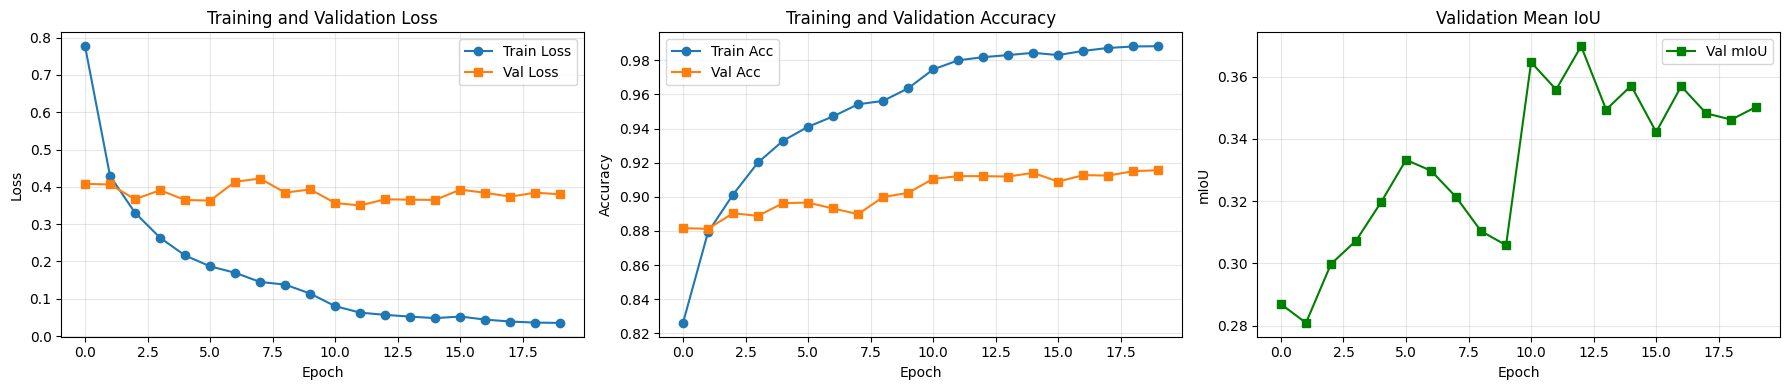

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# mIoU plot
axes[2].plot(history['val_miou'], label='Val mIoU', marker='s', color='green')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('mIoU')
axes[2].set_title('Validation Mean IoU')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/kaggle/working/training_history.png', dpi=150, bbox_inches='tight')
plt.show()

In [14]:
# Compute per-class IoU on validation set
print("\nPer-Class IoU Analysis on Validation Set:")
print("-" * 70)

_, _, _, class_ious = validate(model, val_loader, criterion, device)

# Create results table
results = []
for idx, (cls_name, iou) in enumerate(zip(VOC_CLASSES, class_ious)):
    if not np.isnan(iou):
        results.append({
            'Class': cls_name,
            'IoU': f"{iou:.4f}",
            'IoU_numeric': iou
        })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('IoU_numeric', ascending=False)
results_df = results_df.drop('IoU_numeric', axis=1)
results_df = results_df.reset_index(drop=True)

print(results_df.to_string(index=False))
print(f"\nMean IoU: {np.nanmean(class_ious):.4f}")

# Save results
results_df.to_csv('/kaggle/working/class_iou_results.csv', index=False)
print("\n✓ Results saved to /kaggle/working/class_iou_results.csv")


Per-Class IoU Analysis on Validation Set:
----------------------------------------------------------------------
      Class    IoU
 background 0.9042
     person 0.5105
        dog 0.4501
        cat 0.4318
        bus 0.4070
        car 0.3994
       bird 0.3962
       boat 0.3818
  aeroplane 0.3812
  tvmonitor 0.3747
      train 0.3724
  motorbike 0.3606
      horse 0.2649
      sheep 0.2633
        cow 0.2391
       sofa 0.2349
     bottle 0.2326
pottedplant 0.2301
    bicycle 0.2128
diningtable 0.1982
      chair 0.1098

Mean IoU: 0.3503

✓ Results saved to /kaggle/working/class_iou_results.csv


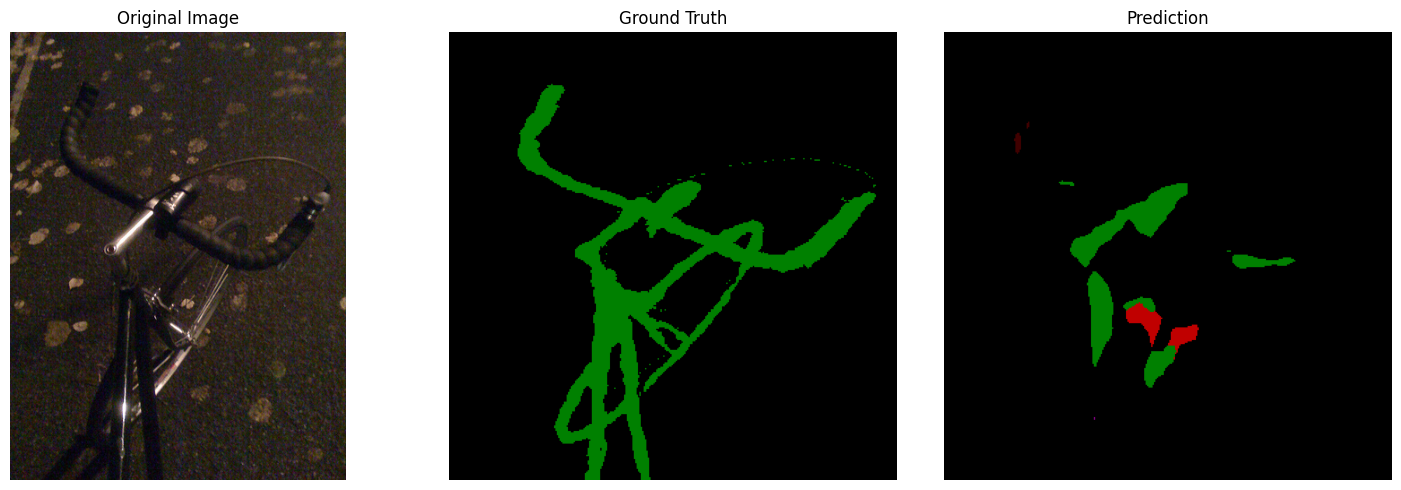


✓ Training and Evaluation Complete!
Best Model: /kaggle/working/best_model.pth
Training History: /kaggle/working/training_history.png
Class IoU Results: /kaggle/working/class_iou_results.csv
Sample Prediction: /kaggle/working/prediction_sample.png


In [15]:
def predict_image(model, img_path, device, img_size=(320, 320)):
    """Predict segmentation mask for a single image"""
    model.eval()
    
    # Load and preprocess image
    img = Image.open(img_path).convert('RGB')
    original_size = img.size
    
    img_resized = img.resize(img_size, Image.BILINEAR)
    img_tensor = transforms.ToTensor()(img_resized)
    img_tensor = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )(img_tensor)
    img_tensor = img_tensor.unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        output = model(img_tensor)['out']
        pred = output.argmax(dim=1).squeeze(0).cpu().numpy()
    
    # Convert to RGB
    pred_rgb = class_index_to_rgb(pred)
    pred_rgb_pil = Image.fromarray(pred_rgb).resize(original_size, Image.NEAREST)
    
    return pred_rgb_pil, pred

# Test on a random validation image
test_id = random.choice(val_ids)
test_img_path = ROOT / 'JPEGImages' / f'{test_id}.jpg'
test_mask_path = ROOT / 'SegmentationClass' / f'{test_id}.png'

pred_rgb, pred_mask = predict_image(model, test_img_path, device)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(Image.open(test_img_path))
axes[0].set_title('Original Image')
axes[0].axis('off')

ground_truth = Image.open(test_mask_path).resize((320, 320), Image.NEAREST)
gt_arr = mask_to_class_index(ground_truth)
gt_rgb = class_index_to_rgb(gt_arr)
axes[1].imshow(gt_rgb)
axes[1].set_title('Ground Truth')
axes[1].axis('off')

axes[2].imshow(class_index_to_rgb(pred_mask))
axes[2].set_title('Prediction')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('/kaggle/working/prediction_sample.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("✓ Training and Evaluation Complete!")
print("="*60)
print(f"Best Model: /kaggle/working/best_model.pth")
print(f"Training History: /kaggle/working/training_history.png")
print(f"Class IoU Results: /kaggle/working/class_iou_results.csv")
print(f"Sample Prediction: /kaggle/working/prediction_sample.png")
print("="*60)